In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import pad_sequences, plot_model
from sklearn.metrics import accuracy_score

from keras.layers import Dense, LSTM, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
import keras.backend as K
from keras.callbacks import ModelCheckpoint
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2024-01-18 19:05:20.451524: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 19:05:21.410262: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 19:05:21.415725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 19:05:23.916235: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
RECORDS_COUNT = 4000 # Quantidade de registros a serem utilizados

with open('./database/iam_words/words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents][18:]
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 


def encode_to_labels(txt): # encoding de cada caractere para dígitos
    dig_lst = []
    for _, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst


In [3]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [4]:

images = []
labels = []

train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

test_images = []
test_labels = []
test_input_length = []
test_label_length = []
test_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []


In [5]:

count = 0
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1] # Verifica se aquela imagem está OK
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = './database/iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            print("Erro to process image for index " + str(index))
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            print("Erro to encode labels for index " + str(index))
            continue
        
        if count % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        elif count % 5 == 0:
            test_images.append(img)
            test_labels.append(label)
            test_input_length.append(31)
            test_label_length.append(len(word))
            test_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
        
        count += 1
        
        if count >= RECORDS_COUNT:
            break

Erro to process image for index 4152


In [6]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

test_padded_label = pad_sequences(test_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

print(train_padded_label.shape, valid_padded_label.shape, test_padded_label.shape)

(3200, 16) (400, 16) (400, 16)


In [7]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

test_images = np.asarray(test_images)
test_input_length = np.asarray(test_input_length)
test_label_length = np.asarray(test_label_length)

## Utilizando LSTM

In [8]:
# Model utilizando para os teste 

inputs = Input(shape=(32,128,1))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
pool_3 = MaxPool2D(pool_size=(2, 1))(conv_3)

conv_4 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_3)
batch_norm = BatchNormalization()(conv_4)
pool_4 = MaxPool2D(pool_size=(2, 1))(batch_norm)
conv_5 = Conv2D(512, (2,2), activation = 'relu')(pool_4)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_5)
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_1)

act_model = Model(inputs, outputs)

act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [10]:
# Model utilizado para o treinamento
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 128, 64)          640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 64, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 64, 128)          73856     ['max_pooling2d[0][0]'] 

                                                                     'the_labels[0][0]',          
                                                                     'input_length[0][0]',        
                                                                     'label_length[0][0]']        
                                                                                                  
Total params: 4216399 (16.08 MB)
Trainable params: 4215375 (16.08 MB)
Non-trainable params: 1024 (4.00 KB)
__________________________________________________________________________________________________


In [14]:
batch_size = 32
epochs = 30
e = str(epochs)
optimizer_name = 'adam'

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]


In [15]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 14.7647 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 13.84197, saving model to adamo-4000r-30e-3200t-400v.hdf5


/home/guilh/guilhermelopeseng/mestrado/sistemas_visao_computacional/cnn_predict_handwriter/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 104s 998ms/step - loss: 14.7647 - accuracy: 0.0000e+00 - val_loss: 13.8420 - val_accuracy: 0.0000e+00
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 11.7656 - accuracy: 0.0206
Epoch 2: val_loss did not improve from 13.84197
100/100 [==============================] - 114s 1s/step - loss: 11.7656 - accuracy: 0.0206 - val_loss: 14.5422 - val_accuracy: 0.0500
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 9.1149 - accuracy: 0.0606
Epoch 3: val_loss improved from 13.84197 to 11.18143, saving model to adamo-4000r-30e-3200t-400v.hdf5
100/100 [==============================] - 89s 887ms/step - loss: 9.1149 - accuracy: 0.0606 - val_loss: 11.1814 - val_accuracy: 0.0100
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 6.8863 - accuracy: 0.1031
Epoch 4: val_loss improved from 11.18143 to 8.77466, saving model to adamo-4000r-30e-3200t-400v.hdf5
100/100 [==============================] - 81s

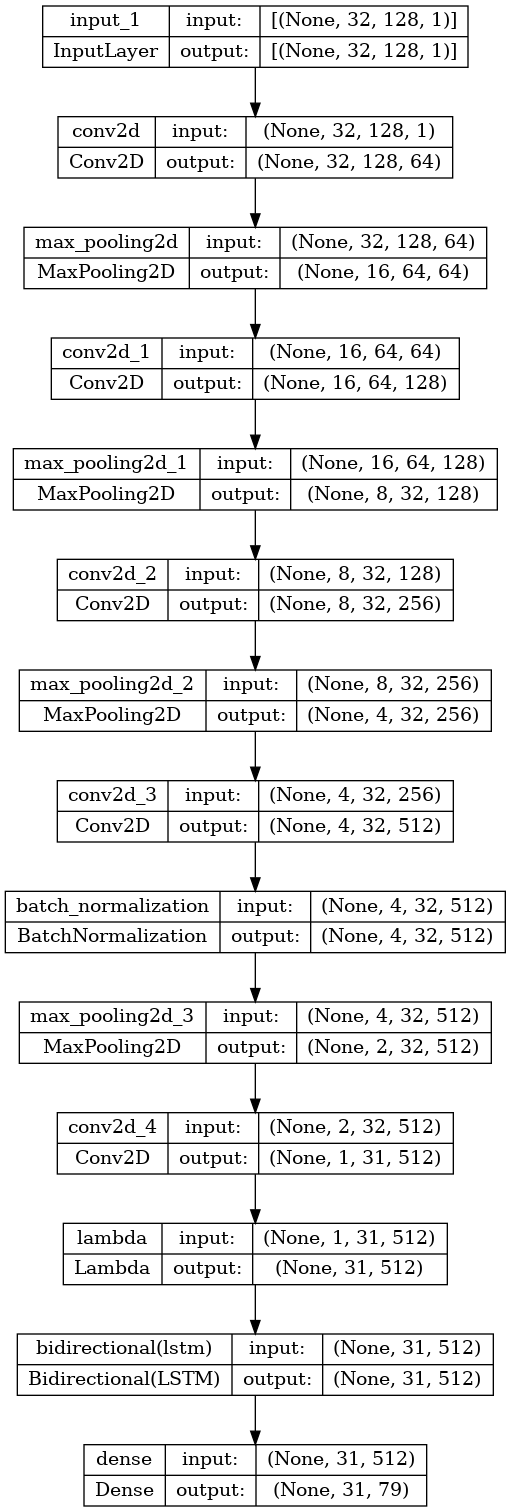

In [16]:
tf.keras.utils.plot_model(
    act_model,
    to_file='model_lstm.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

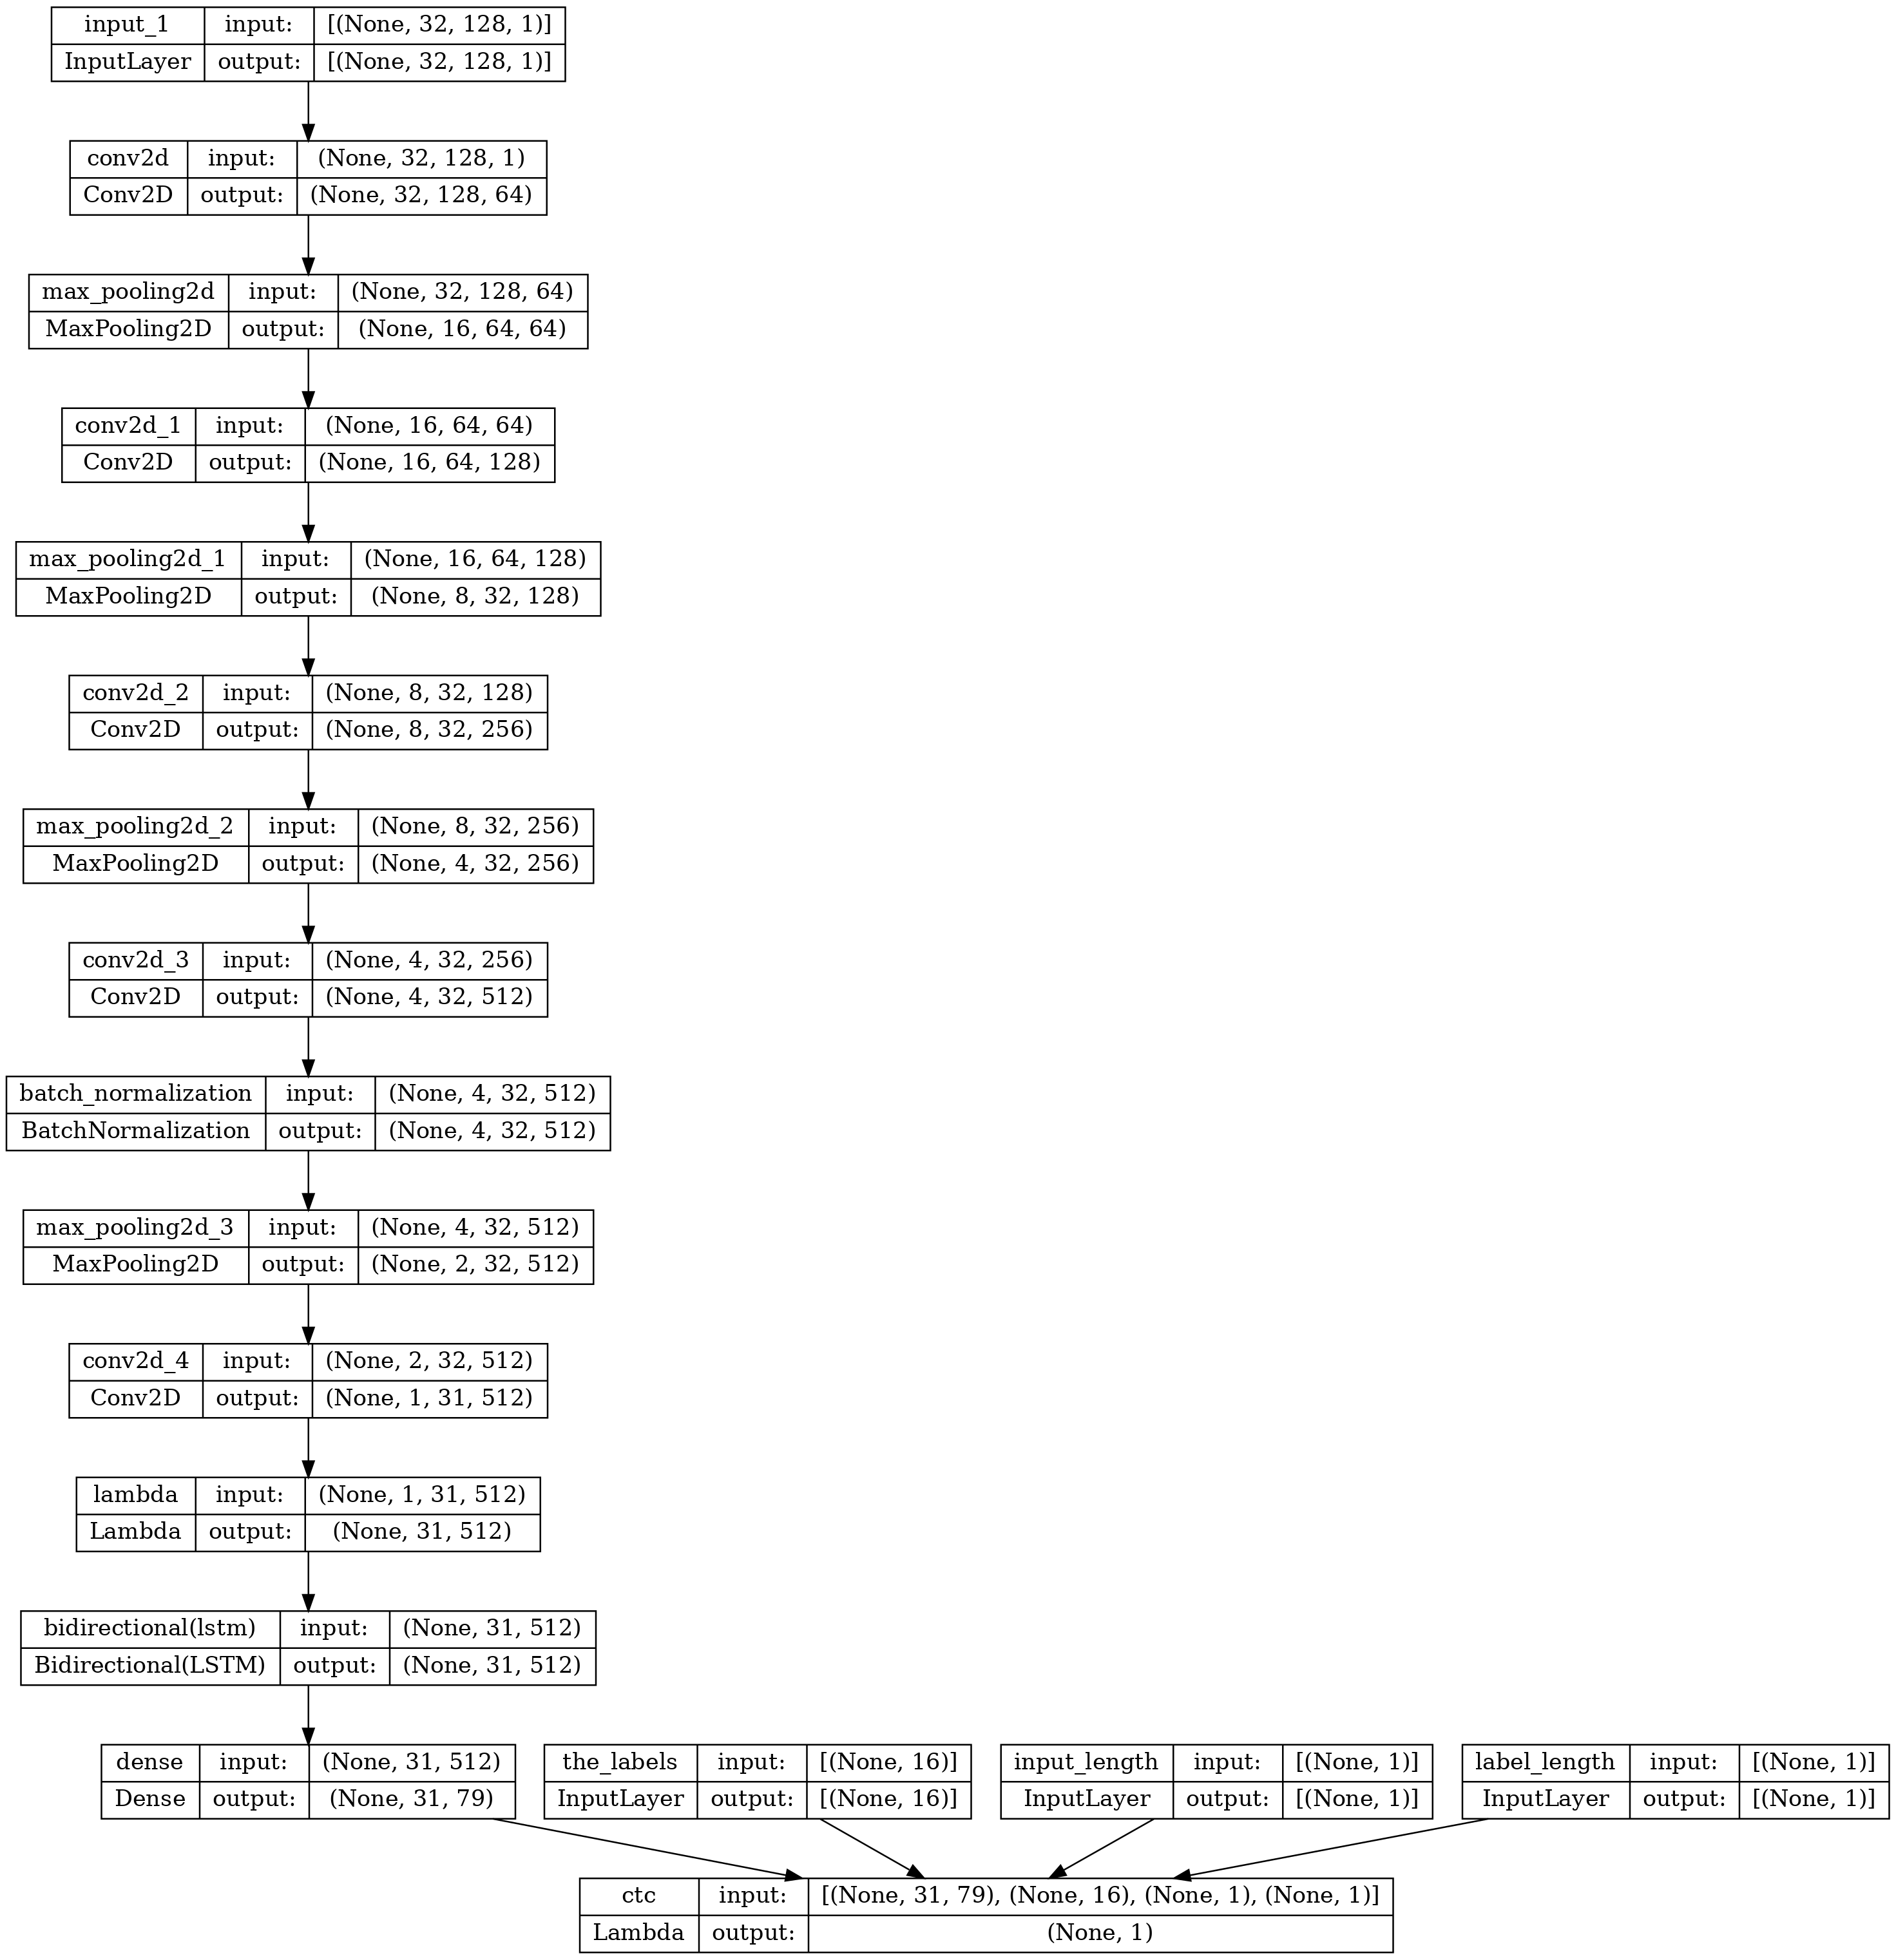

In [17]:
tf.keras.utils.plot_model(
    model,
    to_file='model_treinamento_lstm.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=180,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

13/13 [==============================] - 3s 168ms/step
original_text =   Gaitskell
predicted text = Gaitslebe

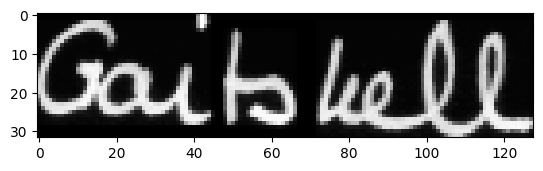



original_text =   be
predicted text = be

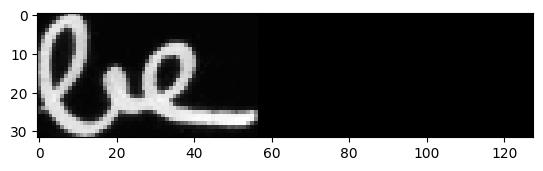



original_text =   resolution
predicted text = resoltion

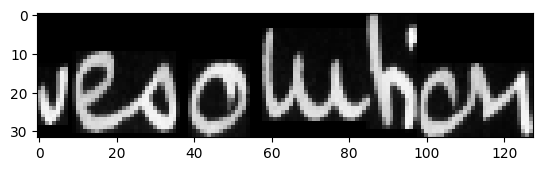



original_text =   .
predicted text = .

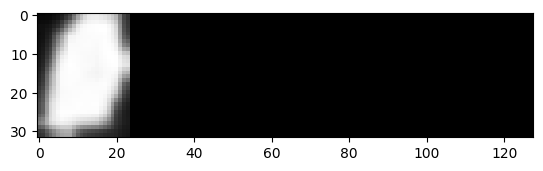

In [18]:
prediction = act_model.predict(test_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)
# see the results
for i, x in enumerate(out[0:4]):
    print("original_text =  ", test_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(test_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

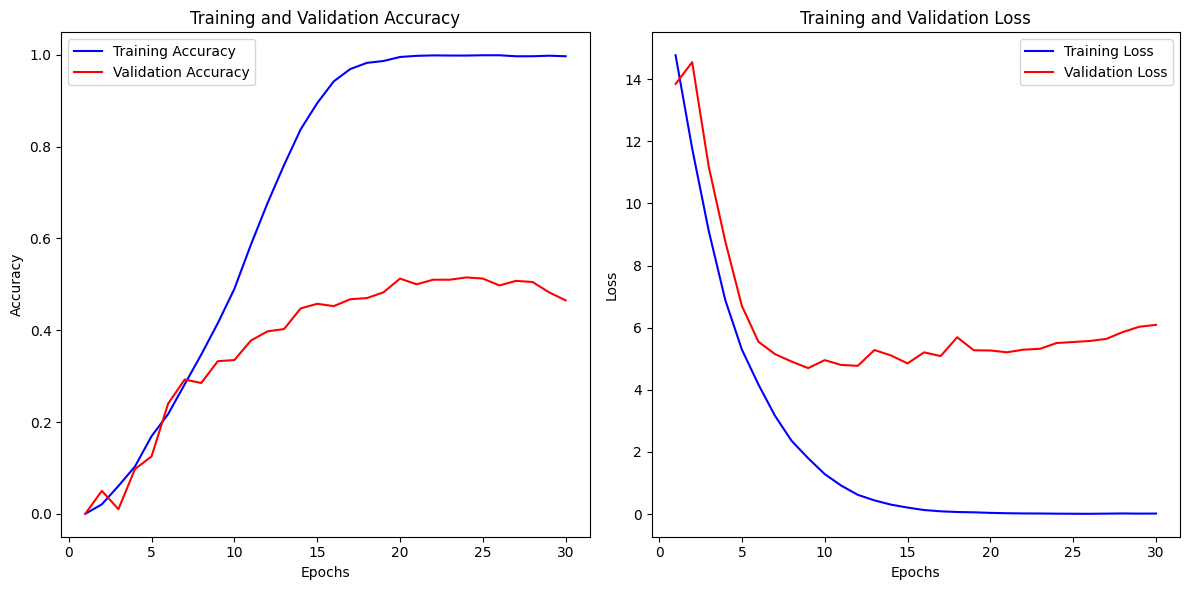

In [19]:
# Extract data from the history object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Save the plot in /kaggle/output/
plot_filename = 'Accuracy_Loss_Plot.png'  # Specify the desired file name and extension
plt.savefig(plot_filename)

plt.tight_layout()
plt.show()

In [20]:
prediction = model.predict([test_images, test_padded_label, test_input_length, test_label_length])
prediction_train = model.predict([train_images, train_padded_label, train_input_length, train_label_length])
prediction_valid = model.predict([valid_images, valid_padded_label, valid_input_length, valid_label_length])

13/13 [==============================] - 3s 200ms/step


In [21]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print(mean_absolute_error(np.zeros(3200), K.squeeze(prediction_train, 1)))
print(mean_absolute_error(np.zeros(400), K.squeeze(prediction, 1)))
print(mean_absolute_error(np.zeros(400), K.squeeze(prediction_valid, 1)))

0.07191448519989535
5.88882720705682
6.090647839142621


## Somente CNN

In [22]:
# Model utilizando para os teste 

inputs = Input(shape=(32,128,1))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
pool_3 = MaxPool2D(pool_size=(2, 1))(conv_3)

conv_4 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_3)
batch_norm = BatchNormalization()(conv_4)
pool_4 = MaxPool2D(pool_size=(2, 1))(batch_norm)
conv_5 = Conv2D(512, (2,2), activation = 'relu')(pool_4)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_5)

outputs = Dense(len(char_list)+1, activation = 'softmax')(squeezed)

act_model = Model(inputs, outputs)

act_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 32, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 32, 256)        2951

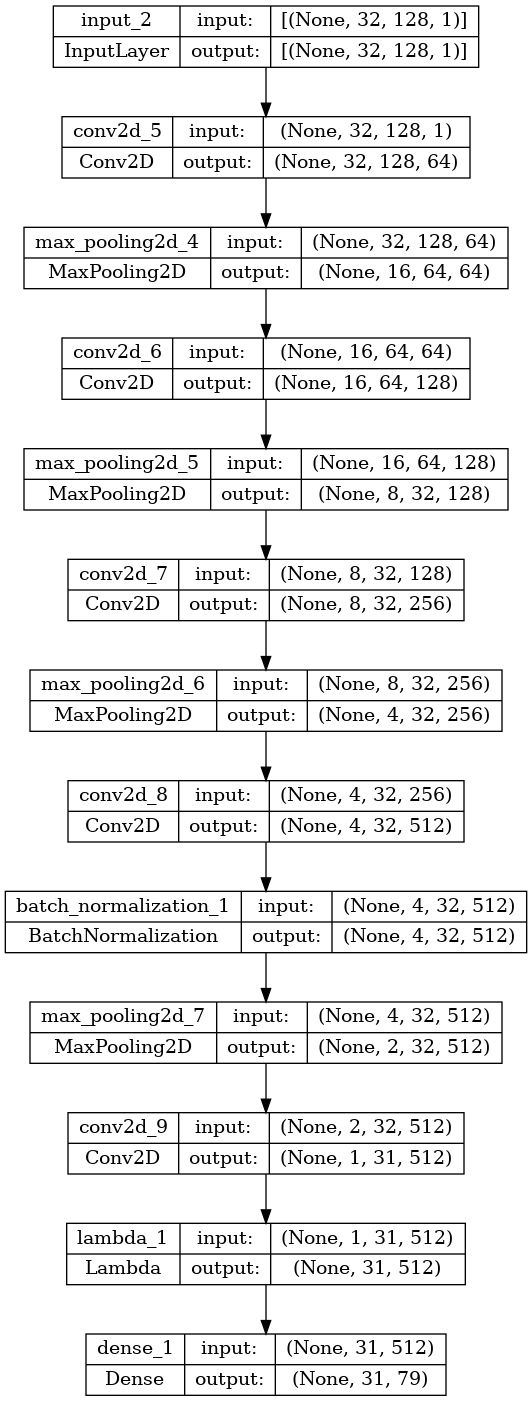

In [23]:
tf.keras.utils.plot_model(
    act_model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [24]:
# Model utilizado para o treinamento
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 128, 64)          640       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 16, 64, 64)           0         ['conv2d_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 64, 128)          73856     ['max_pooling2d_4[0][0]'

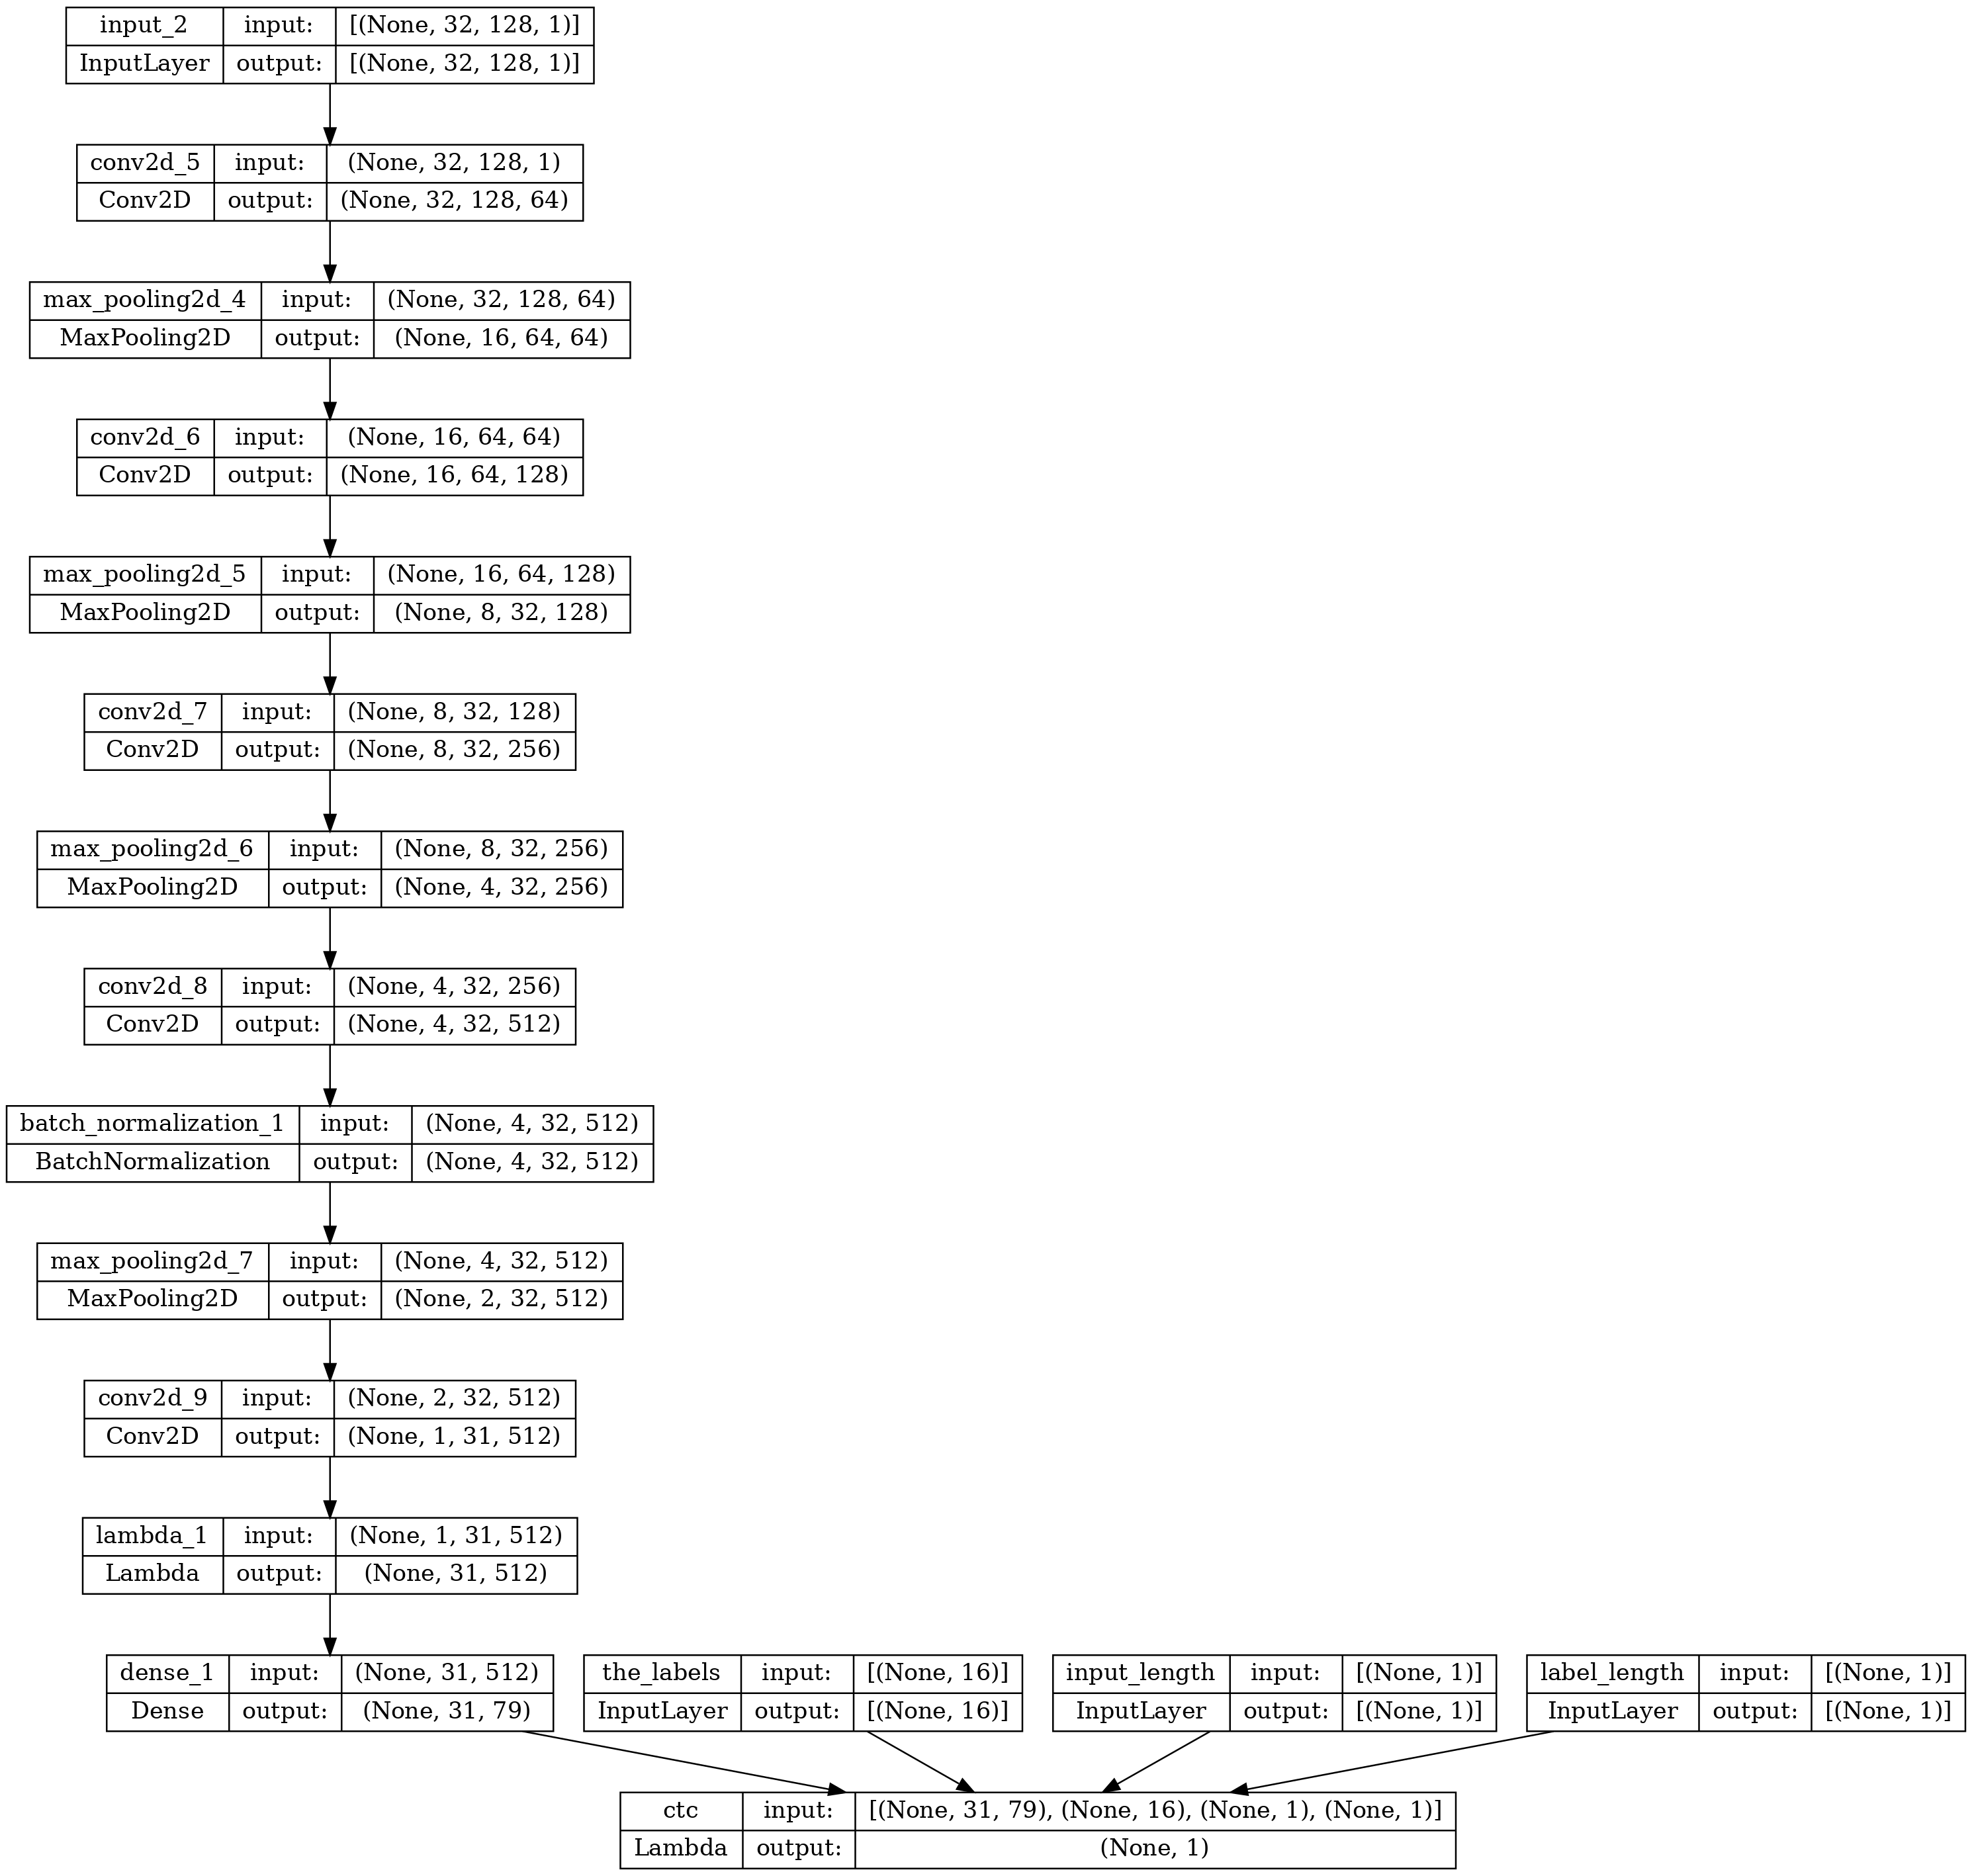

In [25]:
tf.keras.utils.plot_model(
    model,
    to_file='model_treinamento.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=180,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [26]:
batch_size = 32
epochs = 30
e = str(epochs)
optimizer_name = 'adam'

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]


In [27]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 19.0808 - accuracy: 6.2500e-04
Epoch 1: val_loss improved from inf to 90.78512, saving model to adamo-4000r-30e-3200t-400v.hdf5


/home/guilh/guilhermelopeseng/mestrado/sistemas_visao_computacional/cnn_predict_handwriter/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 69s 678ms/step - loss: 19.0808 - accuracy: 6.2500e-04 - val_loss: 90.7851 - val_accuracy: 0.0000e+00
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 12.9565 - accuracy: 0.0234
Epoch 2: val_loss improved from 90.78512 to 57.18806, saving model to adamo-4000r-30e-3200t-400v.hdf5
100/100 [==============================] - 66s 657ms/step - loss: 12.9565 - accuracy: 0.0234 - val_loss: 57.1881 - val_accuracy: 0.0000e+00
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 10.4344 - accuracy: 0.0453
Epoch 3: val_loss improved from 57.18806 to 28.51019, saving model to adamo-4000r-30e-3200t-400v.hdf5
100/100 [==============================] - 62s 625ms/step - loss: 10.4344 - accuracy: 0.0453 - val_loss: 28.5102 - val_accuracy: 0.0000e+00
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 8.0527 - accuracy: 0.0737
Epoch 4: val_loss improved from 28.51019 to 15.21439, saving model to adamo-4000r-

In [28]:
prediction = model.predict([test_images, test_padded_label, test_input_length, test_label_length])
prediction_train = model.predict([train_images, train_padded_label, train_input_length, train_label_length])
prediction_valid = model.predict([valid_images, valid_padded_label, valid_input_length, valid_label_length])

13/13 [==============================] - 1s 111ms/step


In [29]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print(mean_absolute_error(np.zeros(3200), K.squeeze(prediction_train, 1)))
print(mean_absolute_error(np.zeros(400), K.squeeze(prediction, 1)))
print(mean_absolute_error(np.zeros(400), K.squeeze(prediction_valid, 1)))

0.017266988198653053
9.85878882651159
10.07028970982552


13/13 [==============================] - 2s 108ms/step
original_text =   Gaitskell
predicted text = Goitsebe

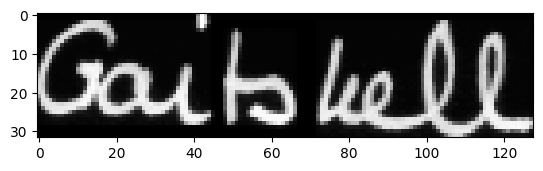



original_text =   be
predicted text = be

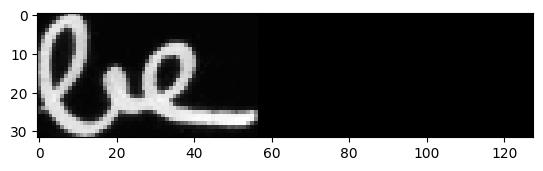



original_text =   resolution
predicted text = vesohtion

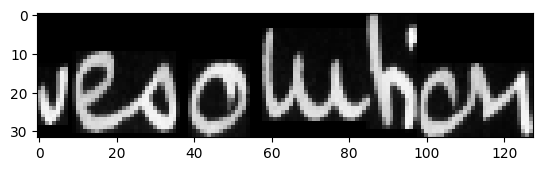



original_text =   .
predicted text = .

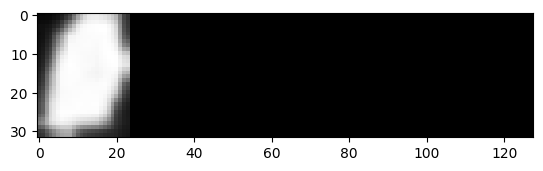

In [30]:
prediction = act_model.predict(test_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)
# see the results
for i, x in enumerate(out[0:4]):
    print("original_text =  ", test_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(test_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

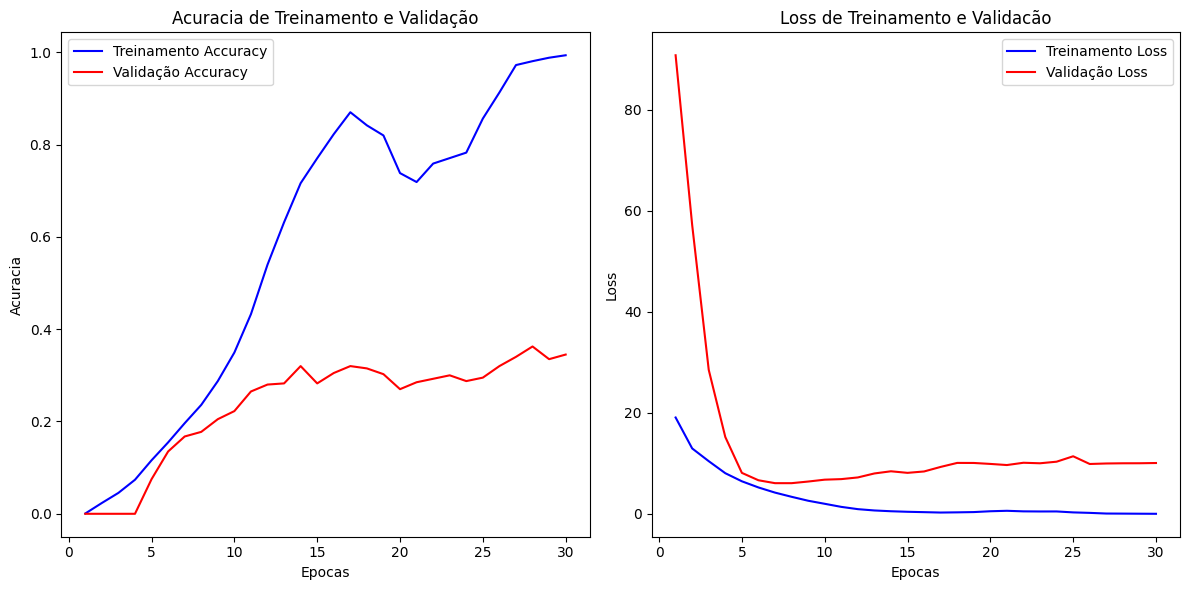

In [31]:
# Extract data from the history object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b", label="Treinamento Accuracy")
plt.plot(epochs, val_acc, "r", label="Validação Accuracy")
plt.title("Acuracia de Treinamento e Validação")
plt.xlabel("Epocas")
plt.ylabel("Acuracia")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Treinamento Loss")
plt.plot(epochs, val_loss, "r", label="Validação Loss")
plt.title("Loss de Treinamento e Validacão")
plt.xlabel("Epocas")
plt.ylabel("Loss")
plt.legend()

# Save the plot in /kaggle/output/
plot_filename = 'Accuracy_Loss_Plot.png'  # Specify the desired file name and extension
plt.savefig(plot_filename)

plt.tight_layout()
plt.show()